In [9]:
import math
import numpy as np
import scipy as sp
from scipy.linalg import eig
from numpy import sin, cos, abs, exp, sqrt, arccos, pi

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [10]:
U = 0.0 # Kerr nonlinearity; units of gamma_T / |a|^2
gamma = 5e-2 # 5e-2 # Total loss rate 5e-2
J = 1.0 # Inter-cavity coupling
N = 500 # Number of cavities
F_value = 1.0 # Pump
Delta = 0.0 # Detuning

In [12]:
def f_RK4(Delta, U, gamma, J, F, a):

    # Open boundary conditions
    a_l = np.concatenate((np.zeros(1), a[:-1]))
    a_r = np.concatenate((a[1:], np.zeros(1)))

    # Periodic boundary conditions
    #a_l = np.concatenate((np.ones(1)*a[-1], a[:-1]))
    #a_r = np.concatenate((a[1:], np.ones(1)*a[0]))

    y = -1.0j * (
        -Delta*a + U*abs(a)**2*a -1.0j*gamma*a - J*a_l - J*a_r + F
    )
    
    return y

N_t = 1e3 # Number of time steps
t_f = 1e2 # Final time
t = np.linspace(0, t_f, int(N_t))
Delta_t = t[1] - t[0]

In [15]:
# Cavity-laser coupling
#Delta_n_list = np.arange(2, 106, 4)
Delta_n_list = np.arange(2, 206, 8)
ll_list = np.zeros(len(Delta_n_list), dtype=np.float64)
a_list = np.zeros(len(Delta_n_list), dtype=np.float64)
a_total_list = np.zeros(len(Delta_n_list), dtype=np.float64)

n1 = 249

for i_Delta_n, Delta_n in enumerate(Delta_n_list):

    print('Delta n = {:}'.format(Delta_n_list[i_Delta_n]))

    # Cavity fields
    a = np.zeros((N, int(N_t)), dtype=np.complex128)

    F = np.zeros(N, dtype=np.complex128)
    n2 = n1 + Delta_n_list[i_Delta_n]
    F[int(n1)] = F_value
    F[int(n2)] = F_value

    for i_t in range(len(t)-1):

        k1 = f_RK4(Delta, U, gamma, J, F, a[:, i_t])
        k2 = f_RK4(Delta, U, gamma, J, F, a[:, i_t] + k1*Delta_t/2)
        k3 = f_RK4(Delta, U, gamma, J, F, a[:, i_t] + k2*Delta_t/2)
        k4 = f_RK4(Delta, U, gamma, J, F, a[:, i_t] + k3*Delta_t)

        a[:, i_t+1] = a[:, i_t] + (k1 + 2*k2 + 2*k3 + k4)*Delta_t/6

    #a[:, 0] = a[:, -1]

    # We define a parameter characterizing the light localization
    ll_list[i_Delta_n] = np.sum(np.abs(a[249+1:249+Delta_n, -1])**2) / np.sum(np.abs(a[:, -1])**2) 
    a_list [i_Delta_n] = np.sum(np.abs(a[249+1:249+Delta_n, -1])**2) 
    a_total_list[i_Delta_n] = np.sum(np.abs(a[:, -1])**2) 

Delta n = 2
Delta n = 10
Delta n = 18
Delta n = 26
Delta n = 34
Delta n = 42
Delta n = 50
Delta n = 58
Delta n = 66
Delta n = 74
Delta n = 82
Delta n = 90
Delta n = 98
Delta n = 106
Delta n = 114
Delta n = 122
Delta n = 130
Delta n = 138
Delta n = 146
Delta n = 154
Delta n = 162
Delta n = 170
Delta n = 178
Delta n = 186
Delta n = 194
Delta n = 202


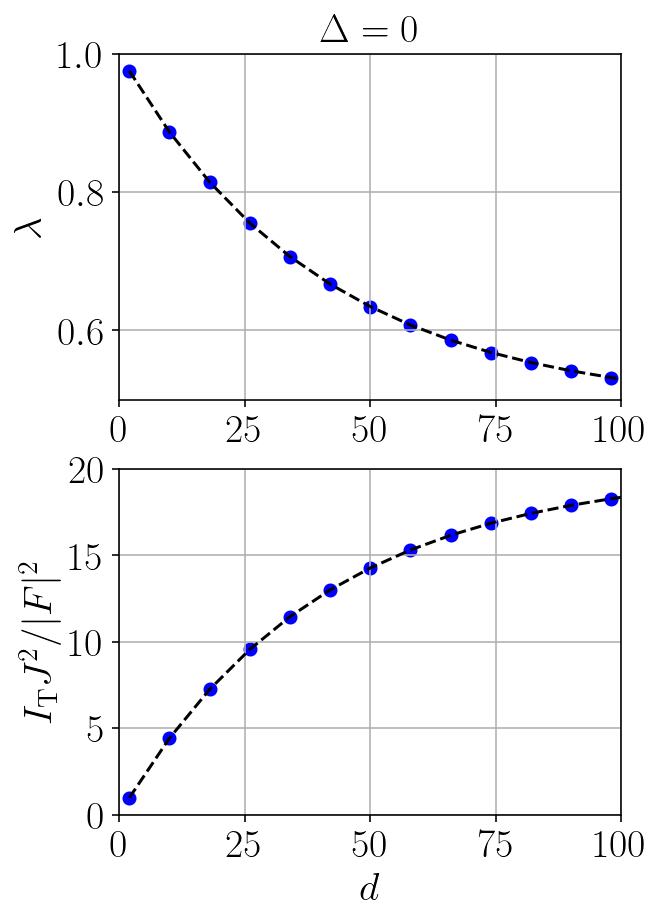

In [16]:
plt.rcParams["figure.figsize"] = [4.5, 7]
fig, ax = plt.subplots(2, 1)
fs = 20
ax[0].grid()
ax[1].grid()

ax[0].scatter(Delta_n_list, ll_list, color='blue')
ax[1].scatter(Delta_n_list, a_total_list, color='blue')

#ax[0].set_ylim([0.0, 1.0])
#ax[0].set_xlabel(r'$d$', fontsize=fs)
ax[0].set_ylabel(r'$\lambda$', fontsize=fs)
ax[0].tick_params(axis='both', labelsize=fs)

ax[0].set_xlim(0, 100)
ax[0].set_ylim(0.5, 1)

#ax[1].set_ylim([0.0, 1.5])
ax[1].set_xlabel(r'$d$', fontsize=fs)
ax[1].set_ylabel(r'$I_{\rm T}J^2/|F|^2$', fontsize=fs)
ax[1].tick_params(axis='both', labelsize=fs)

# From analytic formula
k0 = arccos(-Delta/(2*J))
D = 1/sqrt(4*J**2-Delta**2)
d = Delta_n_list
integral = 2*np.abs(F_value)**2*D/gamma*(1+cos(k0*d)*exp(-gamma*D*d))
n_list = np.linspace(0, N-1, N)
a_n_2_sum = []
for d_i in d:
    n2 = n1 + d_i
    a_n_2_inside = 2*abs(F_value)**2*D**2*exp(-gamma*D*d_i)*(np.cosh(gamma*D*(n2+n1-2*n_list)) + cos(k0*(n2+n1-2*n_list)))
    a_n_2_sum.append(sum(a_n_2_inside[n1+1:n2]))
lambda_ana = np.array(a_n_2_sum) / integral
ax[0].plot(d, lambda_ana, '--k')

# Analytic formulas
k0 = arccos(-Delta/(2*J))
D = 1/sqrt(4*J**2-Delta**2)
d = np.array(Delta_n_list)

integral = 2*np.abs(F_value)**2*D/gamma*(1+cos(k0*d)*exp(-gamma*D*d))
ax[1].plot(Delta_n_list, integral, '--k')

ax[1].set_xlim(0, 100)
ax[1].set_ylim(0, 20)

ax[0].set_xticks([0, 25, 50, 75, 100])
ax[1].set_xticks([0, 25, 50, 75, 100])

ax[0].set_title('$\Delta = {:}$'.format(int(Delta)), fontsize=fs)

estimation = gamma*D/2 * exp(-2*pi*gamma*D)
ax[0].plot([0, 200], [estimation, estimation], '--m')